In [1]:
# Configure Loguru to INFO in Jupyter
import sys
from loguru import logger
from ase.build import molecule
from rdkit import Chem
from rdkit.Chem import AllChem

from neural_optimiser.optimise import BFGS
from neural_optimiser.calculators import RandomCalculator
from neural_optimiser.conformers import ConformerBatch, Conformer
from neural_optimiser.datasets.base import ConformerDataset, ConformerDataLoader

In [2]:
logger.remove()  # avoid duplicate logs across re-runs
logger.add(sys.stdout, level="INFO")

1

## Run a Batched BFGS Optimisation

In [15]:
# Create a batch of molecules (each becomes a conformer)
atoms_list = [molecule("H2O"), molecule("NH3"), molecule("CH3OCH3")]
batch = ConformerBatch.from_ase(atoms_list, device="cpu")

# Configure optimiser and attach a calculator that provides forces
optimiser = BFGS(steps=100, fmax=0.05, fexit=500.0, max_step=0.04)
optimiser.calculator = RandomCalculator()

# Run optimisation
converged = optimiser.run(batch)
print("All Converged:", converged)
for i, (conv, nsteps) in enumerate(zip(batch.converged, batch.converged_step)):
    print(f"Conformer {i}: Converged: {conv}, On step {nsteps}")

# Trajectory [T, N, 3] and converged coordinates [N, 3]
print("pos_dt shape:", tuple(batch.pos_dt.shape))
print("pos_min shape:", tuple(batch.pos_min.shape))

2025-10-05 16:52:29.667 | INFO     | neural_optimiser.optimise._bfgs:__init__:22 - Running BFGS optimiser
2025-10-05 16:52:29.674 | INFO     | neural_optimiser.optimise.base:run:73 - Starting BFGS: nconf=3, natoms=16, steps=100, fmax=0.05, fexit=500.0, max_step=0.04
2025-10-05 16:52:29.728 | INFO     | neural_optimiser.optimise.base:_should_exit:283 - Step limit reached: 100 steps.
2025-10-05 16:52:29.728 | INFO     | neural_optimiser.optimise.base:_run:138 - Exiting after step 100: converged=False
2025-10-05 16:52:29.728 | INFO     | neural_optimiser.optimise.base:_finalise_trajectories:305 - Finalized trajectories: nconf=3, converged=0/3.
All Converged: False
Conformer 0: Converged: False, On step -1
Conformer 1: Converged: False, On step -1
Conformer 2: Converged: False, On step -1
pos_dt shape: (101, 16, 3)
pos_min shape: (16, 3)


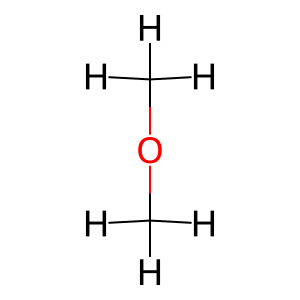

In [16]:
# View the first and last step of the first conformer
initial = batch.conformer(idx=2, step=0).plot(dim=3)
initial

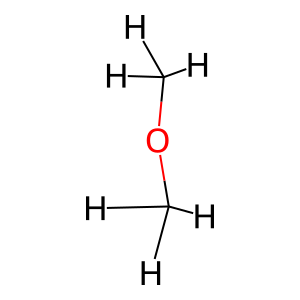

In [17]:
final = batch.conformer(idx=2, step=-1).plot(dim=3)
final

## Run a Larger BFGS Optimisation using the ConformerDataLoader

In [ ]:
# Build a pool of conformers from RDKit molecules
smiles_list = ["CCO", "CC", "CCN"]
mols = []
for smiles in smiles_list:
    m = Chem.AddHs(Chem.MolFromSmiles(smiles))
    AllChem.EmbedMultipleConfs(m, numConfs=10, useExpTorsionAnglePrefs=True, useBasicKnowledge=True)
    mols.append(m)

big_batch = ConformerBatch.from_rdkit(mols)  # creates one Conformer per RDKit conformer

# Dataset/DataLoader -> yields ConformerBatch
dataset = ConformerDataset([big_batch.conformer(i) for i in range(big_batch.n_conformers)])
dataloader = ConformerDataLoader(dataset, batch_size=8, device="cpu", shuffle=True, num_workers=0)

# Configure optimiser and attach a calculator that provides forces
optimiser = BFGS(steps=10, fmax=0.05, fexit=500.0, max_step=0.04)
optimiser.calculator = RandomCalculator()

for batch in dataloader:
    optimiser.run(batch) 

## Data Containers

### Conformers

In [18]:
# From ASE
atoms = molecule("H2O")
conf1 = Conformer.from_ase(atoms, smiles="O")

print(type(conf1).__name__)
print("atom_types:", conf1.atom_types.shape)  # [n_atoms]
print("pos:", conf1.pos.shape)                # [n_atoms, 3]
print("smiles:", conf1.smiles)

# Convert back to ASE
atoms2 = conf1.to_ase()
print("ASE atoms:", atoms2.get_chemical_formula(), atoms2.positions.shape)

Conformer
atom_types: torch.Size([3])
pos: torch.Size([3, 3])
smiles: O
ASE atoms: H2O (3, 3)


In [19]:
# From RDKit
mol = Chem.MolFromSmiles("CCO")
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
conf2 = Conformer.from_rdkit(mol)

# Convert back to RDKit (returns a Mol with one 3D conformer)
mol2 = conf2.to_rdkit()
print("RDKit confs:", mol2.GetNumConformers())

RDKit confs: 1


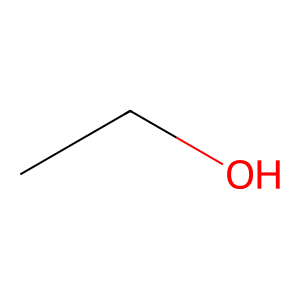

In [20]:
conf2.plot(dim=2)

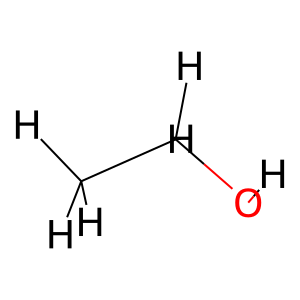

In [21]:
conf2.plot(dim=3)

### ConformerBatch

In [22]:
# Build from ASE
atoms_list = [molecule("H2O"), molecule("NH3"), molecule("CH4")]
batch_ase = ConformerBatch.from_ase(atoms_list, device="cpu")
print("ASE batch:", batch_ase.n_molecules, batch_ase.n_conformers, batch_ase.n_atoms)

# Slice a single conformer view
conf0 = batch_ase.conformer(0)
print("conf0 pos:", conf0.pos.shape)

# Indices available on the batch (per-atom)
print("batch index shape:", batch_ase.batch.shape)
print("molecule_idxs shape:", batch_ase.molecule_idxs.shape)

ASE batch: 3 3 12
conf0 pos: torch.Size([3, 3])
batch index shape: torch.Size([12])
molecule_idxs shape: torch.Size([12])


In [23]:
# Build from RDKit (multiple conformers per molecule also supported)
def rdkit_with_coords(smiles: str):
    m = Chem.MolFromSmiles(smiles)
    m = Chem.AddHs(m)
    AllChem.EmbedMolecule(m, AllChem.ETKDG())
    return m

mol_list = [rdkit_with_coords("O"), rdkit_with_coords("CCO")]
batch_rd = ConformerBatch.from_rdkit(mol_list, device="cpu")
print("RDKit batch:", batch_rd.n_molecules, batch_rd.n_conformers, batch_rd.n_atoms)

# Build from a list of Conformer objects
c1 = Conformer.from_ase(molecule("H2O"))
c2 = Conformer.from_ase(molecule("NH3"))
batch_list = ConformerBatch.from_data_list([c1, c2], device="cpu")
print("Data list batch:", batch_list.n_molecules, batch_list.n_conformers, batch_list.n_atoms)

RDKit batch: 2 2 12
Data list batch: 2 2 7
